# Imports

In [1]:
import torchvision
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import json
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction 
import os 

# Configuration

In [2]:
class Config:
    decoder_id = "distilbert/distilgpt2"
    max_length = 128
    batch_size = 8
    num_frames = 10
    img_size = 224
    num_epochs = 100  
    lr = 3e-5
    csv_path = "/kaggle/input/videocap/processed_data.csv"  
    grad_clip = 1.0
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    seed = 42
    model_save_path = "video_qa_model.pth"
    results_file = "training_results.json"
    patience = 10 
    bleu_smoothing = SmoothingFunction().method1 
    checkpoint_dir = "checkpoints" 
    save_every_epoch = False 
    final_model_path = "final_video_qa_model.pth" 
    best_checkpoint_path = os.path.join("checkpoints", "best_checkpoint.pth") 

# Dataset

In [3]:
# Cell 2: Dataset Class
class VideoQADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_tensor = self._load_video_frames(row['path'])

        text = f"Question: {row['questions']} Answer: {row['refined_answer']}"
        encoding = self.tokenizer(
            text,
            max_length=Config.max_length-1,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'video': video_tensor,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

    def _load_video_frames(self, video_path):
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            while len(frames) < Config.num_frames:
                ret, frame = cap.read()
                if not ret: break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (Config.img_size, Config.img_size))
                frames.append(frame)
            cap.release()
        except Exception as e:
            print(f"Error loading {video_path}: {e}")
            # Handle corrupted video by returning black frames instead of crashing
            return torch.zeros((Config.num_frames, 3, Config.img_size, Config.img_size))


        if not frames:
            frames = [np.zeros((Config.img_size, Config.img_size, 3), dtype=np.uint8)] * Config.num_frames

        frames = frames[:Config.num_frames]
        if len(frames) < Config.num_frames:
            frames += [frames[-1]] * (Config.num_frames - len(frames))

        video_tensor = torch.tensor(np.array(frames)).float() / 255.0
        return video_tensor.permute(0, 3, 1, 2)


# Model Architecture

In [4]:
class VideoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load EfficientNet with correct feature extraction
        self.backbone = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 
                                     'nvidia_efficientnet_b0', 
                                     pretrained=True)
        
        # Remove classification head while preserving final features
        self.backbone = nn.Sequential(
            *list(self.backbone.children())[:-1],  # Keep features before final pooling
            nn.AdaptiveAvgPool2d(1)  # Add proper spatial pooling
        )
        
        # Freeze all backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Verify feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            self.feature_dim = features.view(-1).shape[0]
        
        # Temporal aggregation
        self.temporal_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        
        # Normalization (now handled in dataset class)
        features = self.backbone(x).squeeze()
        
        # Reshape and temporal pooling
        features = features.view(B, T, -1).permute(0, 2, 1)
        return self.temporal_pool(features).squeeze(-1)

class VideoQAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VideoEncoder()
        self.decoder = AutoModelForCausalLM.from_pretrained(Config.decoder_id)
        
        # Dynamic projection based on actual encoder output
        self.proj = nn.Linear(self.encoder.feature_dim, self.decoder.config.hidden_size)

    def forward(self, video, input_ids, attention_mask, labels=None):
        video_features = self.encoder(video)
        video_features = self.proj(video_features)

        text_embeds = self.decoder.get_input_embeddings()(input_ids)
        combined_embeds = torch.cat([video_features.unsqueeze(1), text_embeds], dim=1)
        combined_mask = torch.cat([
            torch.ones(video.size(0), 1).to(attention_mask.device),
            attention_mask
        ], dim=1)

        if labels is not None:
            labels = torch.cat([
                torch.full((input_ids.size(0), 1), -100,
                          device=labels.device,
                          dtype=torch.long),
                input_ids
            ], dim=1)

        return self.decoder(
            inputs_embeds=combined_embeds,
            attention_mask=combined_mask,
            labels=labels
        )

# Data Preparation

In [5]:
df = pd.read_csv(Config.csv_path)
train_df, test_df = train_test_split(
    df,
    test_size=1-Config.train_ratio,
    stratify=df['class'],
    random_state=Config.seed
)

val_df, test_df = train_test_split(
    test_df,
    test_size=Config.test_ratio/(Config.test_ratio+Config.val_ratio),
    stratify=test_df['class'],
    random_state=Config.seed
)

print(f"Dataset sizes:")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Dataset sizes:
Train: 4766
Validation: 1022
Test: 1022


# Training Setup

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

tokenizer = AutoTokenizer.from_pretrained(Config.decoder_id)
train_dataset = VideoQADataset(train_df, tokenizer)
val_dataset = VideoQADataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=2) 
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, num_workers=2)

model = VideoQAModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=Config.lr)
scaler = torch.cuda.amp.GradScaler()


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<ipython-input-6-2e7f1552e229>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Training 

In [7]:
best_val_loss = float('inf')
training_log = []
epochs_no_improve = 0 # Counter for early stopping

train_losses = [] 
val_losses = []

# Create checkpoint directory if it doesn't exist
os.makedirs(Config.checkpoint_dir, exist_ok=True)

for epoch in range(Config.num_epochs):
    # Training
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.num_epochs} [Training]")

    for batch in progress_bar:
        optimizer.zero_grad()

        video = batch['video'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)


        with torch.cuda.amp.autocast():
            outputs = model(video, input_ids, attention_mask, labels=input_ids)
            loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.grad_clip)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss) 


    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.num_epochs} [Validating]")
        for batch in val_progress_bar:
            video = batch['video'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(video, input_ids, attention_mask, labels=input_ids) 
            val_loss += outputs.loss.item()
            val_progress_bar.set_postfix({'loss': outputs.loss.item()})

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss) 


    # Early stopping check and Best Checkpoint Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), Config.model_save_path) # Save best model based on validation loss

        # Save best checkpoint
        checkpoint_path = Config.best_checkpoint_path
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"\nEpoch {epoch+1}: Validation loss improved, saved new best model to {Config.model_save_path} and best checkpoint to {checkpoint_path}")

        epochs_no_improve = 0 
    else:
        epochs_no_improve += 1
        print(f"\nEpoch {epoch+1}: Validation loss did not improve ({epochs_no_improve}/{Config.patience})")
        if epochs_no_improve >= Config.patience:
            print(f"Early stopping triggered after {Config.patience} epochs without improvement.")
            break # Stop training loop

    # Log metrics
    epoch_log = {
        'epoch': epoch+1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss
    }
    training_log.append(epoch_log)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {epoch_log['train_loss']:.4f}")
    print(f"Val Loss: {epoch_log['val_loss']:.4f}")

Epoch 1/100 [Training]:   0%|          | 0/596 [00:00<?, ?it/s]<ipython-input-7-718089307c58>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100 [Validating]: 100%|██████████| 128/128 [01:15<00:00,  1.69it/s, loss=1.2]



Epoch 1: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 1 Summary:
Train Loss: 1.1625
Val Loss: 0.8349


Epoch 2/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=1.11]



Epoch 2: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 2 Summary:
Train Loss: 0.8185
Val Loss: 0.7640


Epoch 3/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=1.08]



Epoch 3: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 3 Summary:
Train Loss: 0.7526
Val Loss: 0.7304


Epoch 4/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=1.06]



Epoch 4: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 4 Summary:
Train Loss: 0.7104
Val Loss: 0.7110


Epoch 5/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=1.05]



Epoch 5: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 5 Summary:
Train Loss: 0.6857
Val Loss: 0.7017


Epoch 6/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=1.04]



Epoch 6: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 6 Summary:
Train Loss: 0.6692
Val Loss: 0.6914


Epoch 7/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=1.02]



Epoch 7: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 7 Summary:
Train Loss: 0.6528
Val Loss: 0.6830


Epoch 8/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=1.01]



Epoch 8: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 8 Summary:
Train Loss: 0.6355
Val Loss: 0.6777


Epoch 9/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=1.01]



Epoch 9: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 9 Summary:
Train Loss: 0.6277
Val Loss: 0.6735


Epoch 10/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=1]



Epoch 10: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 10 Summary:
Train Loss: 0.6184
Val Loss: 0.6699


Epoch 11/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=1]



Epoch 11: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 11 Summary:
Train Loss: 0.6064
Val Loss: 0.6664


Epoch 12/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=1]



Epoch 12: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 12 Summary:
Train Loss: 0.5999
Val Loss: 0.6659


Epoch 13/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=0.999]



Epoch 13: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 13 Summary:
Train Loss: 0.5948
Val Loss: 0.6657


Epoch 14/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.66it/s, loss=0.999]



Epoch 14: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 14 Summary:
Train Loss: 0.5883
Val Loss: 0.6630


Epoch 15/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=0.996]



Epoch 15: Validation loss did not improve (1/10)

Epoch 15 Summary:
Train Loss: 0.5817
Val Loss: 0.6632


Epoch 16/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s, loss=0.99]



Epoch 16: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 16 Summary:
Train Loss: 0.5795
Val Loss: 0.6611


Epoch 17/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.64it/s, loss=0.992]



Epoch 17: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 17 Summary:
Train Loss: 0.5764
Val Loss: 0.6600


Epoch 18/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.64it/s, loss=0.993]



Epoch 18: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 18 Summary:
Train Loss: 0.5705
Val Loss: 0.6594


Epoch 19/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=0.992]



Epoch 19: Validation loss did not improve (1/10)

Epoch 19 Summary:
Train Loss: 0.5687
Val Loss: 0.6617


Epoch 20/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.68it/s, loss=0.991]



Epoch 20: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 20 Summary:
Train Loss: 0.5693
Val Loss: 0.6578


Epoch 21/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.66it/s, loss=0.993]



Epoch 21: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 21 Summary:
Train Loss: 0.5661
Val Loss: 0.6577


Epoch 22/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=0.992]



Epoch 22: Validation loss did not improve (1/10)

Epoch 22 Summary:
Train Loss: 0.5620
Val Loss: 0.6579


Epoch 23/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.66it/s, loss=0.994]



Epoch 23: Validation loss did not improve (2/10)

Epoch 23 Summary:
Train Loss: 0.5557
Val Loss: 0.6583


Epoch 24/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=0.991]



Epoch 24: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 24 Summary:
Train Loss: 0.5528
Val Loss: 0.6573


Epoch 25/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=0.989]



Epoch 25: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 25 Summary:
Train Loss: 0.5504
Val Loss: 0.6558


Epoch 26/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s, loss=0.992]



Epoch 26: Validation loss did not improve (1/10)

Epoch 26 Summary:
Train Loss: 0.5488
Val Loss: 0.6577


Epoch 27/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.62it/s, loss=0.999]



Epoch 27: Validation loss did not improve (2/10)

Epoch 27 Summary:
Train Loss: 0.5467
Val Loss: 0.6574


Epoch 28/100 [Validating]: 100%|██████████| 128/128 [01:19<00:00,  1.61it/s, loss=0.998]



Epoch 28: Validation loss did not improve (3/10)

Epoch 28 Summary:
Train Loss: 0.5444
Val Loss: 0.6575


Epoch 29/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=0.995]



Epoch 29: Validation loss did not improve (4/10)

Epoch 29 Summary:
Train Loss: 0.5421
Val Loss: 0.6559


Epoch 30/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=0.995]



Epoch 30: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 30 Summary:
Train Loss: 0.5401
Val Loss: 0.6557


Epoch 31/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.64it/s, loss=0.994]



Epoch 31: Validation loss did not improve (1/10)

Epoch 31 Summary:
Train Loss: 0.5378
Val Loss: 0.6568


Epoch 32/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=1]



Epoch 32: Validation loss did not improve (2/10)

Epoch 32 Summary:
Train Loss: 0.5357
Val Loss: 0.6559


Epoch 33/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=0.998]



Epoch 33: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 33 Summary:
Train Loss: 0.5334
Val Loss: 0.6552


Epoch 34/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s, loss=0.99]



Epoch 34: Validation loss did not improve (1/10)

Epoch 34 Summary:
Train Loss: 0.5322
Val Loss: 0.6558


Epoch 35/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s, loss=0.999]



Epoch 35: Validation loss did not improve (2/10)

Epoch 35 Summary:
Train Loss: 0.5295
Val Loss: 0.6557


Epoch 36/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s, loss=0.989]



Epoch 36: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 36 Summary:
Train Loss: 0.5275
Val Loss: 0.6551


Epoch 37/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.62it/s, loss=0.992]



Epoch 37: Validation loss did not improve (1/10)

Epoch 37 Summary:
Train Loss: 0.5259
Val Loss: 0.6552


Epoch 38/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.63it/s, loss=0.997]



Epoch 38: Validation loss did not improve (2/10)

Epoch 38 Summary:
Train Loss: 0.5228
Val Loss: 0.6563


Epoch 39/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=0.999]



Epoch 39: Validation loss did not improve (3/10)

Epoch 39 Summary:
Train Loss: 0.5216
Val Loss: 0.6570


Epoch 40/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=0.997]



Epoch 40: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 40 Summary:
Train Loss: 0.5205
Val Loss: 0.6549


Epoch 41/100 [Validating]: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s, loss=0.997]



Epoch 41: Validation loss did not improve (1/10)

Epoch 41 Summary:
Train Loss: 0.5179
Val Loss: 0.6560


Epoch 42/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.64it/s, loss=0.999]



Epoch 42: Validation loss did not improve (2/10)

Epoch 42 Summary:
Train Loss: 0.5155
Val Loss: 0.6572


Epoch 43/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=1.01]



Epoch 43: Validation loss did not improve (3/10)

Epoch 43 Summary:
Train Loss: 0.5128
Val Loss: 0.6585


Epoch 44/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=1]



Epoch 44: Validation loss did not improve (4/10)

Epoch 44 Summary:
Train Loss: 0.5113
Val Loss: 0.6571


Epoch 45/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=0.998]



Epoch 45: Validation loss did not improve (5/10)

Epoch 45 Summary:
Train Loss: 0.5093
Val Loss: 0.6592


Epoch 46/100 [Validating]: 100%|██████████| 128/128 [01:18<00:00,  1.64it/s, loss=1]



Epoch 46: Validation loss did not improve (6/10)

Epoch 46 Summary:
Train Loss: 0.5076
Val Loss: 0.6575


Epoch 47/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=1.01]



Epoch 47: Validation loss did not improve (7/10)

Epoch 47 Summary:
Train Loss: 0.5051
Val Loss: 0.6575


Epoch 48/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.64it/s, loss=1]



Epoch 48: Validation loss did not improve (8/10)

Epoch 48 Summary:
Train Loss: 0.5039
Val Loss: 0.6590


Epoch 49/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.66it/s, loss=1.01]



Epoch 49: Validation loss did not improve (9/10)

Epoch 49 Summary:
Train Loss: 0.5023
Val Loss: 0.6600


Epoch 50/100 [Validating]: 100%|██████████| 128/128 [01:17<00:00,  1.65it/s, loss=1]


Epoch 50: Validation loss did not improve (10/10)
Early stopping triggered after 10 epochs without improvement.


# Model Saving

In [8]:
torch.save(model.state_dict(), Config.final_model_path)
print(f"Final model saved to {Config.final_model_path}") 

Final model saved to final_video_qa_model.pth


# Loss Graph

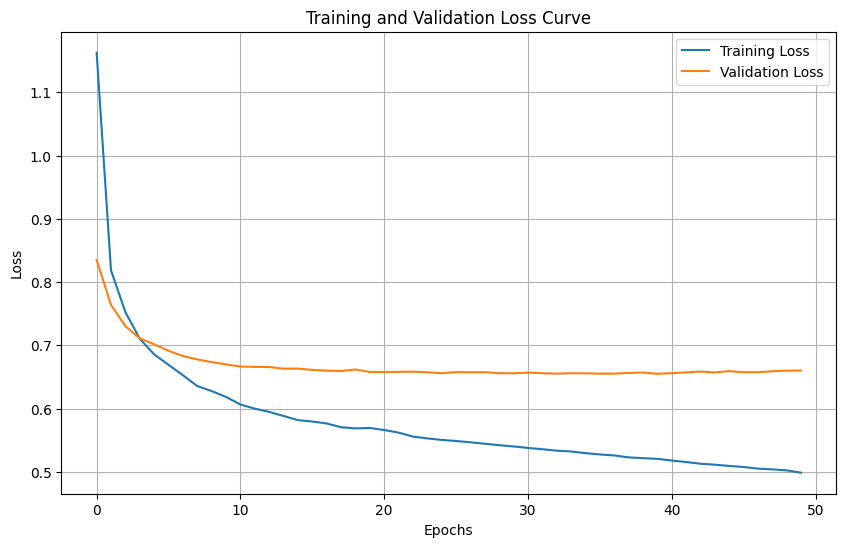

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig('loss_graph.png')
plt.show()

# Testing and Evaluation

In [10]:
model.load_state_dict(torch.load(Config.model_save_path))
model.eval()

test_dataset = VideoQADataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size)

all_preds = []
all_labels = []
test_loss = 0
examples = []
bleu_scores = [] 

with torch.no_grad():
    test_progress_bar = tqdm(test_loader, desc="Testing")
    for batch in test_progress_bar:
        video = batch['video'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = input_ids 

        outputs = model(video, input_ids, attention_mask, labels=labels)
        test_loss += outputs.loss.item()

        preds = torch.argmax(outputs.logits, dim=-1)
        predicted_tokens = preds.cpu().numpy()
        label_tokens = labels.cpu().numpy()


        # Decode tokens and calculate BLEU
        for i in range(len(predicted_tokens)):
            predicted_answer = tokenizer.decode(predicted_tokens[i], skip_special_tokens=True)
            actual_answer = test_df.iloc[test_progress_bar.n * Config.batch_size + i]['refined_answer']

            # Calculate BLEU score for each sample
            try: 
                bleu = sentence_bleu([actual_answer.split()], predicted_answer.split(), smoothing_function=Config.bleu_smoothing) # Use smoothing from config
                bleu_scores.append(bleu)
            except Exception as e:
                print(f"Error calculating BLEU score for example: {e}")
                bleu_scores.append(0.0) 

        all_preds.extend(predicted_tokens)
        all_labels.extend(label_tokens)


        # Save first 3 examples
        if len(examples) < 3 and test_progress_bar.n < 3 :
            for i in range(min(3, len(video))):
                examples.append({
                    'question': test_df.iloc[test_progress_bar.n * Config.batch_size + i]['questions'],
                    'predicted': tokenizer.decode(predicted_tokens[i], skip_special_tokens=True),
                    'actual': test_df.iloc[test_progress_bar.n * Config.batch_size + i]['refined_answer']
                })

# Calculate average BLEU score
average_bleu = np.mean(bleu_scores) if bleu_scores else 0.0


print("\nTest Results:")
print(f"Loss: {test_loss/len(test_loader):.4f}")
print(f"BLEU Score: {average_bleu:.4f}") 


print("\nExample Predictions:")
for ex in examples:
    print(f"\nQuestion: {ex['question']}")
    print(f"Predicted: {ex['predicted']}")
    print(f"Actual: {ex['actual']}")

print(f"\nSaved full results to {Config.results_file}")
print(f"Loss graph saved to loss_graph.png")
print(f"Best checkpoint saved in {Config.best_checkpoint_path}")
print(f"Best model saved to {Config.model_save_path}")
print(f"Final model saved to {Config.final_model_path}")

<ipython-input-10-8e62642c04b3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Config.model_save_path))
Testing: 100%|██████████| 128/128 


Test Results:
Loss: 0.6599
BLEU Score: 0.1895

Example Predictions:

Question: How many are dancing in the video?
Predicted: Question: What many people dancing in the video? Answer: In video showcases a individuals performing in the Kumuni dance performance,
Actual: The video showcases six dancers participating in the Maruni dance performance.

Question: What type of area is depicted?
Predicted: Question: What is of area is depicted? Answer: The area depicted in the video frames is a traditional space or, likely a rural or a community area for cultural performances, as indicated by the presence of a instruments andtheally the the Chyabrung drum) and the dressed in traditional Limbu attire,
Actual: The area depicted in the video frames is a performing arts area, likely a stage or a designated space for cultural performances, as evidenced by the presence of musical instruments (specifically, the Chyabrung drum) and performers dressed in traditional Limbu attire.

Question: Where is the 

In [11]:
results = {
    'config': {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict, type(None))) else v for k, v in vars(Config).items()}, # Convert non-serializable config values to strings
    'training_log': training_log,
    'test_metrics': {
        'loss': test_loss/len(test_loader),
        'bleu_score': average_bleu # Save BLEU score
    },
    'examples': examples
}


# Saving the results

In [12]:
with open(Config.results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nSaved full results to {Config.results_file}")
print(f"Loss graph saved to loss_graph.png")
print(f"Checkpoints saved in {Config.checkpoint_dir} directory")
print(f"Best model saved to {Config.model_save_path}")
print(f"Final model saved to {Config.final_model_path}")


Saved full results to training_results.json
Loss graph saved to loss_graph.png
Checkpoints saved in checkpoints directory
Best model saved to video_qa_model.pth
Final model saved to final_video_qa_model.pth
